In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import shap

# Load the dataset (corrected: use read_csv since it's comma-separated)
df = pd.read_csv('chem452_accum_properties.txt')

print(df.shape)

(344, 22)


In [2]:
df = df.drop(columns=['Accumulation E. coli'])

# Step 1: Remove duplicate rows
df = df.drop_duplicates()
print(df.shape)

# Step 2: Drop rows with missing values
df = df.dropna()
print(df.shape)

(344, 21)
(332, 21)


586.8915662650602
694.8077312630078


Text(0.5, 0, 'Accumulation P. aeruginosa PAO1')

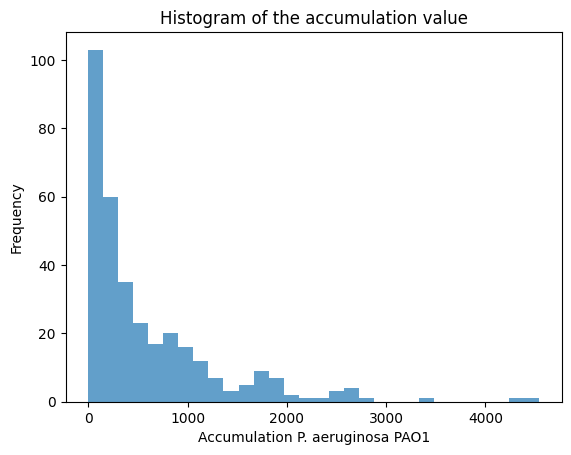

In [3]:
mean = np.mean(df['Accumulation P. aeruginosa PAO1'])
std = np.std(df['Accumulation P. aeruginosa PAO1'])
print(mean)
print(std)

df['Accumulation P. aeruginosa PAO1'].plot.hist(bins=30, alpha=0.7)
plt.title('Histogram of the accumulation value')
plt.xlabel('Accumulation P. aeruginosa PAO1')

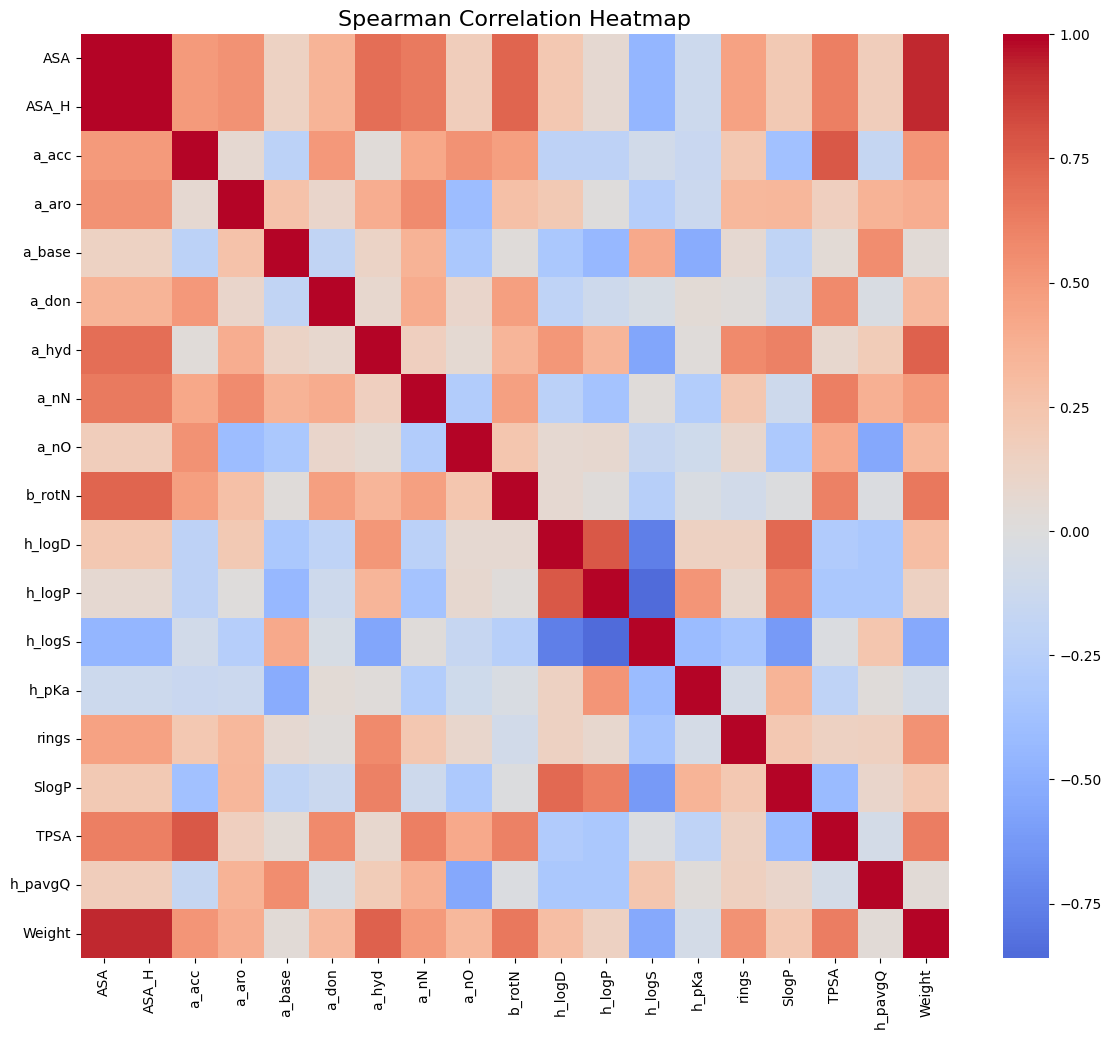

Top 10 features correlated with P. aeruginosa accumulation (Spearman):
h_pavgQ    0.517896
a_base     0.503149
a_nO       0.489975
a_aro      0.459432
a_nN       0.401407
h_logP     0.330433
h_logS     0.216347
ASA        0.209615
ASA_H      0.209615
h_logD     0.205763
Name: Accumulation P. aeruginosa PAO1, dtype: float64


In [4]:
# -----------------------------
# 1. Compute Spearman correlation matrix
# -----------------------------
corr = df.drop(columns=["SMILES"]).corr(method="spearman")

# -----------------------------
# 2. Plot heatmap
# -----------------------------
plt.figure(figsize=(14,12))
filtered_corr = corr.drop(index=["Accumulation P. aeruginosa PAO1"],
                          columns=["Accumulation P. aeruginosa PAO1"])

sns.heatmap(filtered_corr, cmap="coolwarm", center=0)


plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.show()

# -----------------------------
# 3. Extract correlations with accumulation targets
# Drop both self-correlation and the other accumulation target
corr_pseudo = corr["Accumulation P. aeruginosa PAO1"].drop(
    ["Accumulation P. aeruginosa PAO1"]
)
# -----------------------------
# 4. Get Top 10 features for each target
# -----------------------------
top10_pseudo = corr_pseudo.abs().sort_values(ascending=False).head(10)


print("Top 10 features correlated with P. aeruginosa accumulation (Spearman):")
print(top10_pseudo)

Best Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
R² for test set: 0.5770457757901293
R² for training set: 0.9337280627298116
RMSE for test set: 435.9172230725161
RMSE for training set: 180.42253240665124


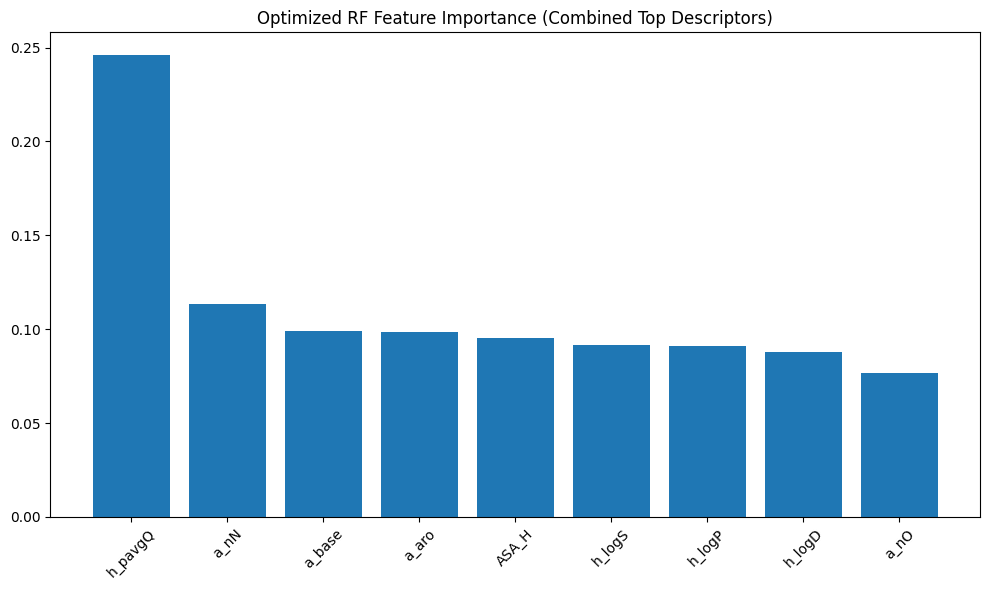

In [5]:
# remove ASA as ASA and ASA_H correlates strongly with each other

combined_features = ["h_pavgQ", "a_base", 'a_nO', 'a_aro', 'a_nN', 'h_logP', 'h_logS', 'ASA_H', 'h_logD']

X = df[combined_features]
y = df["Accumulation P. aeruginosa PAO1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_arr = np.array(y_train)

X_scalar = StandardScaler()
y_scalar = StandardScaler()

X_train_scale = X_scalar.fit_transform(X_train)
y_train_scale = y_scalar.fit_transform(y_train_arr.reshape(-1,1)).ravel()


param_dist_RF = {
    "n_estimators": [100, 300, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5]  # removed 'auto'
}

# -----------------------------
# 5. Run RandomizedSearchCV
# -----------------------------
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_RF,
    n_iter=30,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

# -----------------------------
# 6. Evaluate best model
# -----------------------------
best_rf = search.best_estimator_
y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

print("Best Parameters:", search.best_params_)
print("R² for test set:", r2_score(y_test, y_pred_test_rf))
print("R² for training set:", r2_score(y_train, y_pred_train_rf))
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
print("RMSE for test set:", rmse_rf_test)
print("RMSE for training set:", rmse_rf_train)



# -----------------------------
# 7. Feature Importance Plot
# -----------------------------
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(combined_features)), importances[indices])
plt.xticks(range(len(combined_features)),
           [combined_features[i] for i in indices],
           rotation=45)
plt.title("Optimized RF Feature Importance (Combined Top Descriptors)")
plt.tight_layout()
plt.show()

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30}
R² for test set: 0.6008874233261263
R² for training set: 0.793535567741384
RMSE for test set: 423.45284161108
RMSE for training set: 318.4553609917029


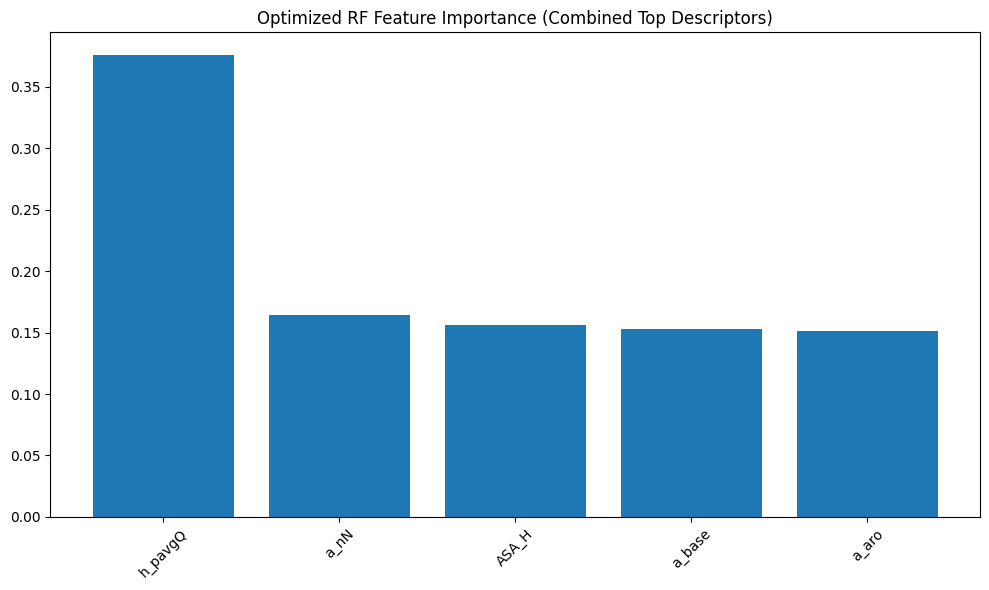

In [6]:
# remove feature one by one based on importance to see if performance of model improve
# stop removing features until model performance stops to improve
# performance does not improve after remove ASA_H

combined_features = ["h_pavgQ", "a_base", 'a_aro', 'a_nN', 'ASA_H']

X = df[combined_features]
y = df["Accumulation P. aeruginosa PAO1"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_arr = np.array(y_train)

X_scalar = StandardScaler()
y_scalar = StandardScaler()

X_train_scale = X_scalar.fit_transform(X_train)
y_train_scale = y_scalar.fit_transform(y_train_arr.reshape(-1,1)).ravel()


param_dist_RF = {
    "n_estimators": [100, 300, 500, 800],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5]  # removed 'auto'
}

# -----------------------------
# 5. Run RandomizedSearchCV
# -----------------------------
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_RF,
    n_iter=30,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

# -----------------------------
# 6. Evaluate best model
# -----------------------------
best_rf = search.best_estimator_
y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

print("Best Parameters:", search.best_params_)
print("R² for test set:", r2_score(y_test, y_pred_test_rf))
print("R² for training set:", r2_score(y_train, y_pred_train_rf))
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
print("RMSE for test set:", rmse_rf_test)
print("RMSE for training set:", rmse_rf_train)



# -----------------------------
# 7. Feature Importance Plot
# -----------------------------
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(combined_features)), importances[indices])
plt.xticks(range(len(combined_features)),
           [combined_features[i] for i in indices],
           rotation=45)
plt.title("Optimized RF Feature Importance (Combined Top Descriptors)")
plt.tight_layout()
plt.show()

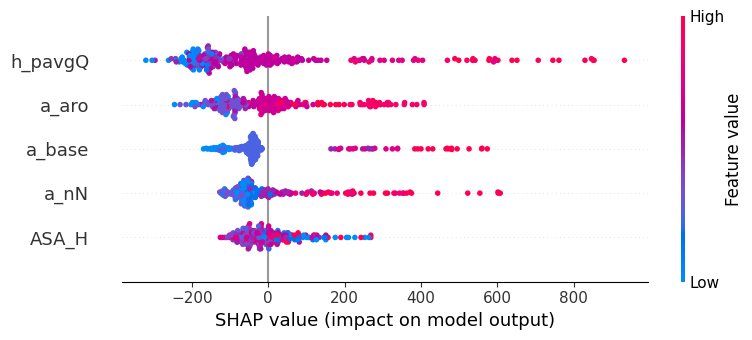

In [7]:
# SHAP Analysis

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X.columns)

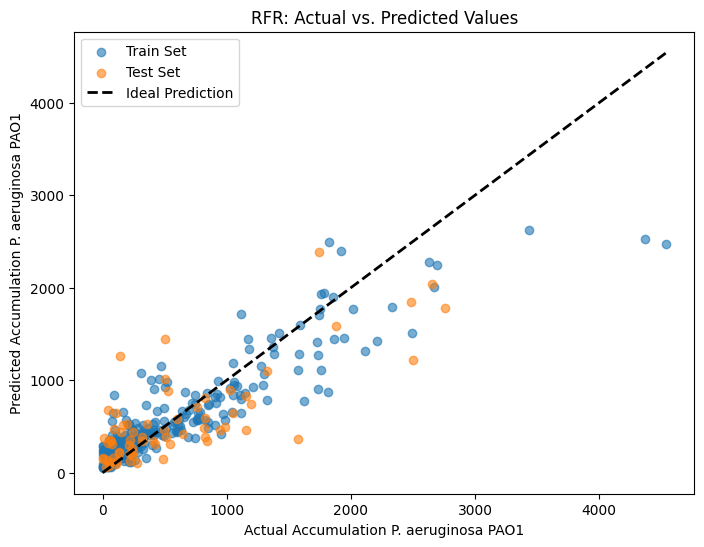

In [8]:
# save figure

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_train_rf, label='Train Set', alpha=0.6)
plt.scatter(y_test, y_pred_test_rf, label='Test Set', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Accumulation P. aeruginosa PAO1')
plt.ylabel('Predicted Accumulation P. aeruginosa PAO1')
plt.title('RFR: Actual vs. Predicted Values')
plt.legend()
plt.savefig('RFR.png', dpi=300)
plt.show()

In [9]:
# Kernel ridge regression

param_grid_KRR = {
    "kernel": ["rbf", "laplacian", "poly"],
    "alpha": [0.01, 0.1, 1, 10],
    "gamma": [1e-3, 1e-2, 1e-1, 1],
}

grid_KRR = GridSearchCV(KernelRidge(), param_grid=param_grid_KRR, cv=5, scoring='r2')
grid_KRR.fit(X_train_scale, y_train_scale)

print(grid_KRR.best_params_)

{'alpha': 0.1, 'gamma': 0.1, 'kernel': 'laplacian'}


In [10]:
# apply best model on training set

best_KRR = KernelRidge(alpha=0.1, gamma=0.1, kernel='laplacian')

best_KRR.fit(X_train_scale, y_train_scale)
y_predict_train_scale = best_KRR.predict(X_train_scale).reshape(-1,1)
y_predict_train = y_scalar.inverse_transform(y_predict_train_scale)

r2_KRR_train = r2_score(y_train_arr, y_predict_train)
rmse_KRR_train = np.sqrt(mean_squared_error(y_train_arr, y_predict_train))

print(f'r2 score for KRR training set: {r2_KRR_train}')
print(f'rmse score for KRR training set: {rmse_KRR_train}')

r2 score for KRR training set: 0.8075042266182844
rmse score for KRR training set: 307.4939251642003


In [11]:
# validate with test set

X_test_scale = X_scalar.transform(X_test)

y_predict_test_scale = best_KRR.predict(X_test_scale)
y_predict_test = y_scalar.inverse_transform(y_predict_test_scale.reshape(-1,1)).ravel()

r2_KRR_test = r2_score(y_test, y_predict_test)
rmse_KRR_test = np.sqrt(mean_squared_error(y_test, y_predict_test))

print(f'r2 score for KRR test set: {r2_KRR_test}')
print(f'rmse score for KRR test set: {rmse_KRR_test}')


r2 score for KRR test set: 0.524254361879023
rmse score for KRR test set: 462.32220468633903


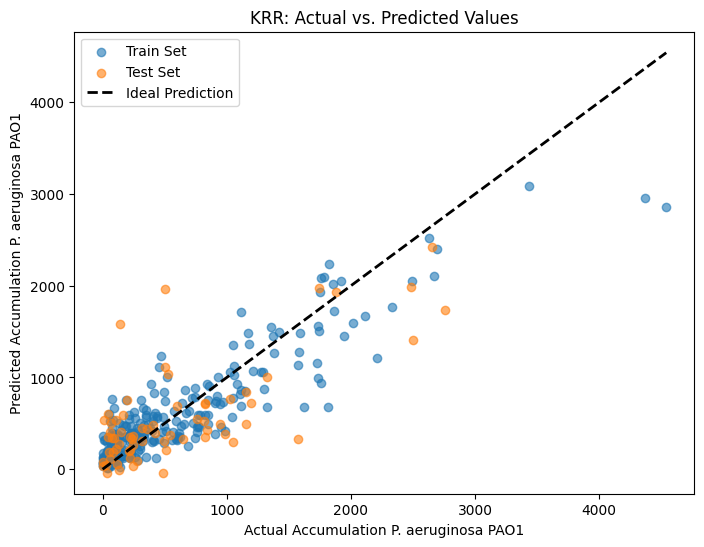

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_predict_train, label='Train Set', alpha=0.6)
plt.scatter(y_test, y_predict_test, label='Test Set', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Accumulation P. aeruginosa PAO1')
plt.ylabel('Predicted Accumulation P. aeruginosa PAO1')
plt.title('KRR: Actual vs. Predicted Values')
plt.legend()
plt.savefig('KRR.png', dpi=300)
plt.show()


In [13]:
# support vector regression

param_grid_SVR = {
    "kernel": ["rbf", "linear", "poly"],
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 1e-3, 1e-2, 1e-1],
    "epsilon": [0.01, 0.1, 0.2, 0.5],
}

grid_SVR = GridSearchCV(SVR(), param_grid=param_grid_SVR, cv=5, scoring="r2")

grid_SVR.fit(X_train_scale, y_train_scale)
print(grid_SVR.best_params_)

{'C': 10, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}


In [14]:
best_SVR = SVR(C=10, epsilon=0.01, gamma=0.1, kernel='rbf')

best_SVR.fit(X_train_scale, y_train_scale)
y_predict_train_scale_SVR = best_SVR.predict(X_train_scale).reshape(-1,1)
y_predict_train_SVR = y_scalar.inverse_transform(y_predict_train_scale_SVR)

r2_SVR_train = r2_score(y_train_arr, y_predict_train_SVR)
rmse_SVR_train = np.sqrt(mean_squared_error(y_train_arr, y_predict_train_SVR))

print(f'r2 score for SVR training set: {r2_SVR_train}')
print(f'rmse score for SVR training set: {rmse_SVR_train}')

r2 score for SVR training set: 0.6295897131145992
rmse score for SVR training set: 426.54755885990585


In [15]:
y_predict_test_scale_SVR = best_SVR.predict(X_test_scale)
y_predict_test_SVR = y_scalar.inverse_transform(y_predict_test_scale_SVR.reshape(-1,1)).ravel()

r2_SVR_test = r2_score(y_test, y_predict_test_SVR)
rmse_SVR_test = np.sqrt(mean_squared_error(y_test, y_predict_test_SVR))

print(f'r2 score for SVR test set: {r2_SVR_test}')
print(f'rmse score for SVR test set: {rmse_SVR_test}')

r2 score for SVR test set: 0.40272137920755335
rmse score for SVR test set: 518.0191677212968


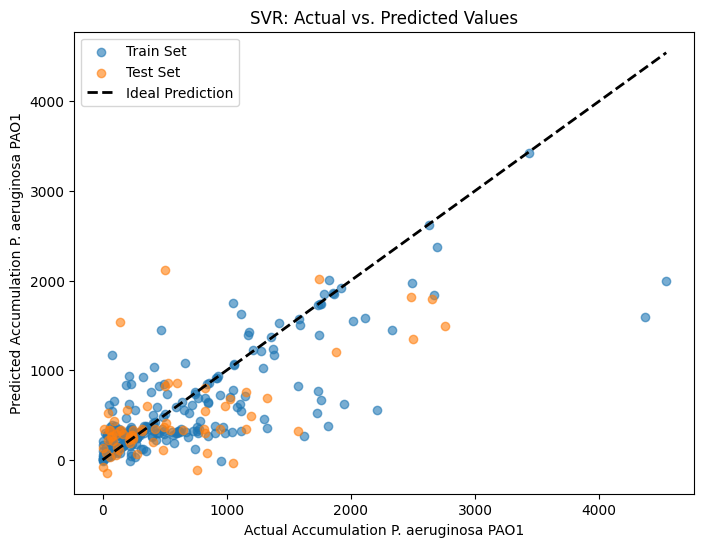

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_predict_train_SVR, label='Train Set', alpha=0.6)
plt.scatter(y_test, y_predict_test_SVR, label='Test Set', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Accumulation P. aeruginosa PAO1')
plt.ylabel('Predicted Accumulation P. aeruginosa PAO1')
plt.title('SVR: Actual vs. Predicted Values')
plt.legend()
plt.savefig('SVR.png', dpi=300)
plt.show()

In [17]:
# Ridge regression

param_grid_Ridge = {
    "alpha": [0.01, 0.1, 1, 10, 100]
}

# Setup GridSearchCV for Ridge Regression
grid_Ridge = GridSearchCV(Ridge(), param_grid=param_grid_Ridge, cv=5, scoring='r2')
grid_Ridge.fit(X_train_scale, y_train_scale)

print(grid_Ridge.best_params_)

{'alpha': 10}


In [18]:
ridge_best_train = Ridge(**grid_Ridge.best_params_)
ridge_best_train.fit(X_train_scale, y_train_scale)
y_predict_train_scale_Ridge = ridge_best_train.predict(X_train_scale)
y_predict_train_Ridge = y_scalar.inverse_transform(y_predict_train_scale_Ridge.reshape(-1, 1))

r2_Ridge_train = r2_score(y_train, y_predict_train_Ridge)
rmse_Ridge_train = np.sqrt(mean_squared_error(y_train, y_predict_train_Ridge))

print(f"R2 Score (Train): {r2_Ridge_train}")
print(f"RMSE (Train): {rmse_Ridge_train}")

X_test_scale = X_scalar.transform(X_test)
y_predict_test_scale_Ridge = ridge_best_train.predict(X_test_scale)
y_predict_test_Ridge = y_scalar.inverse_transform(y_predict_test_scale_Ridge.reshape(-1, 1))

r2_Ridge_test = r2_score(y_test, y_predict_test_Ridge)
rmse_Ridge_test = np.sqrt(mean_squared_error(y_test, y_predict_test_Ridge))

print(f"R2 Score (Test): {r2_Ridge_test}")
print(f"RMSE (Test): {rmse_Ridge_test}")

R2 Score (Train): 0.4082369082613936
RMSE (Train): 539.1379197266288
R2 Score (Test): 0.34135481597655215
RMSE (Test): 543.9802161205284


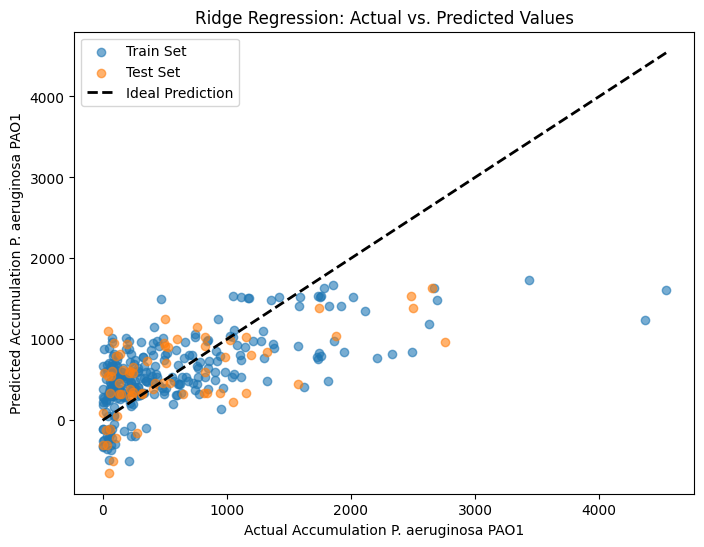

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_predict_train_Ridge, label='Train Set', alpha=0.6)
plt.scatter(y_test, y_predict_test_Ridge, label='Test Set', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Accumulation P. aeruginosa PAO1')
plt.ylabel('Predicted Accumulation P. aeruginosa PAO1')
plt.title('Ridge Regression: Actual vs. Predicted Values')
plt.legend()
#plt.grid(True)
plt.savefig('Ridge_Regression.png', dpi=300)
plt.show()

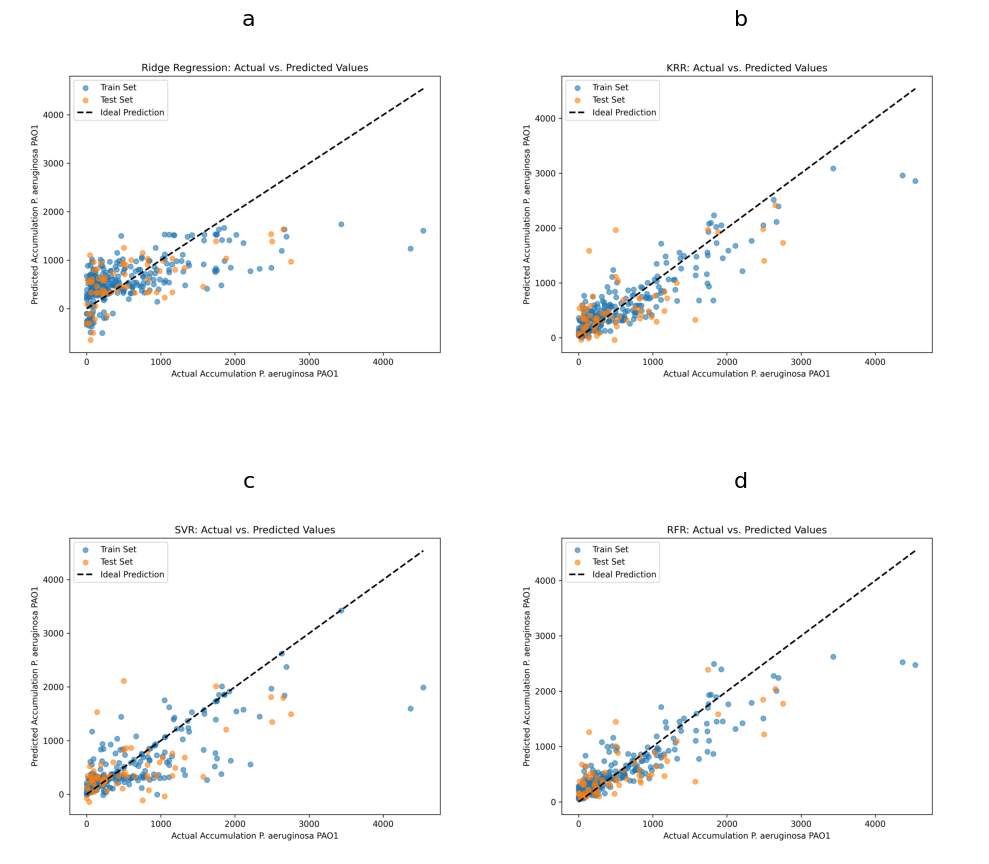

<Figure size 640x480 with 0 Axes>

In [20]:
# save subplot of each figure
img_a = mpimg.imread("Ridge_Regression.png")
img_b = mpimg.imread("KRR.png")
img_c = mpimg.imread("SVR.png")
img_d = mpimg.imread("RFR.png")

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot each image with labels
axes[0, 0].imshow(img_a)
axes[0, 0].set_title("a", fontsize=16)
axes[0, 0].axis("off")

axes[0, 1].imshow(img_b)
axes[0, 1].set_title("b", fontsize=16)
axes[0, 1].axis("off")

axes[1, 0].imshow(img_c)
axes[1, 0].set_title("c", fontsize=16)
axes[1, 0].axis("off")

axes[1, 1].imshow(img_d)
axes[1, 1].set_title("d", fontsize=16)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()
plt.savefig('Summary.png', dpi=300)
